# Purpose: Combine methane atmospheric concentration estimates from Julian years 1-2017, from references at the end of this notebook, and do a logistic fit to the year 200-1749 estimates

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import csv
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17CH4')

Read three input files separately and assign the year values and methane concentration data

In [2]:
df1 = pd.read_excel('cage17lawdome1-2004nov02_ud.xlsx')
df1.to_csv('cage17lawdome1-2004nov02_ud.csv',header=False,index=False)
df1 = pd.read_csv('cage17lawdome1-2004nov02_ud.csv')
df1.drop(df1.index[[-1]],inplace=True)
df1.drop(df1.columns[5], axis=1,inplace=True)
print (df1)

df2 = pd.read_excel('NOAA_MoleFractions_2016_ud.xlsx')
df2.to_csv('NOAA_MoleFractions_2016_ud.csv',header=False,index=False)
df2 = pd.read_csv('NOAA_MoleFractions_2016_ud.csv')
df2.drop(df2.index[[-1]],inplace=True)

df3 = pd.read_excel('NOAAESRL.xlsx')
df3.to_csv('NOAAESRL.csv',header=False,index=False)
df3 = pd.read_csv('NOAAESRL.csv')
df3.drop(df3.index[[-1]],inplace=True)
df3.drop(df3.columns[2:6], axis=1,inplace=True)

     YearAD  CH4spl  NOAA04 CO2spl N2Ospl
0         1   647.6   655.5  276.7  264.2
1         2   647.1     655  276.8  264.1
2         3   646.5   654.4  276.8  264.1
3         4     646   653.9  276.9    264
4         5   645.5   653.4  276.9    264
5         6     645   652.9    277  263.9
6         7   644.5   652.3  277.1  263.8
7         8     644   651.8  277.1  263.8
8         9   643.4   651.3  277.2  263.7
9        10   642.9   650.8  277.2  263.7
10       11   642.4   650.3  277.3  263.6
11       12   641.9   649.8  277.3  263.6
12       13   641.4   649.3  277.4  263.5
13       14     641   648.8  277.4  263.5
14       15   640.5   648.3  277.5  263.4
15       16     640   647.8  277.5  263.4
16       17   639.5   647.3  277.6  263.4
17       18     639   646.8  277.6  263.3
18       19   638.6   646.4  277.6  263.3
19       20   638.1   645.9  277.7  263.2
20       21   637.7   645.5  277.7  263.2
21       22   637.2     645  277.7  263.2
22       23   636.8   644.6  277.8

Prepare for the nomenclature for the output excel sheet

In [3]:
out1 = 'heat'
out2 = 'ch4-1-2017'
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-') # split the date string we create by symbol "-"
yrs = str(int(date_split[0])-2000) # real years minus 2000 
seq = [out1, yrs, out2,months[int(date_split[1])-1],date_split[2]]
seperator = ','
filename = seperator.join(seq).replace(',', '')

Combine CH4 concentration estimates, after rescaling Law Dome to NOAA

In [4]:
yrslaw = df1.iloc[:,0:1]
newyrslaw = yrslaw['YearAD'].tolist()
newyrslaw = list(map(float, newyrslaw))
ch4law = df1.iloc[:, 2:3]
df1 = pd.merge(yrslaw,ch4law, left_index =True, right_index =True,how='outer')
df1 = df1.astype(float)
yrsnoaa = df2.iloc[:,0:1]
yrsnoaa = yrsnoaa['Year'].tolist()
yrsnoaa = list(map(float, yrsnoaa))
newyrsnoaa = [x -0.5 for x in yrsnoaa]
yrsnoaa = list(map(str, newyrsnoaa))
yrsnoaa = pd.DataFrame({'Year':yrsnoaa})
noaa = len(yrsnoaa)
ch4noaa = df2.iloc[:,2:3]
df2 = pd.merge(yrsnoaa,ch4noaa, left_index =True, right_index =True,how='outer')
df2 = df2.astype(float)
c1 = newyrsnoaa
c2 = newyrslaw
yrsboth = list(set(c1) & set(c2))
a = yrsboth[0]
b = yrsboth[-1]
ch4lawboth = ch4law[newyrslaw.index(a):newyrslaw.index(b)+1]
ch4noaaboth = ch4noaa[0:len(yrsboth)]
ch4noaaboth = ch4noaaboth['CH4'].tolist()
ch4noaaboth = list(map(float, ch4noaaboth))
ch4lawboth = ch4lawboth['NOAA04'].tolist()
ch4lawboth = list(map(float, ch4lawboth))
rescalelaw = ch4noaaboth[0]/ch4lawboth[0]
ratio2017vs2016 = float(df3.iloc[-1,-1])/float(df3.iloc[-2,-1])
yrs = list(range(1, 2018))
ch4law = ch4law.astype(float)
ch4law *= float(rescalelaw)
ch4law.drop(ch4law.index[-int((1+newyrslaw[-1]-newyrsnoaa[0])):-1],inplace=True,axis=0) 
ch4law = ch4law[:-1]
ch4law = ch4law['NOAA04'].tolist()
ch4law = list(map(float, ch4law))
ch4noaa = ch4noaa['CH4'].tolist()
ch4noaa = list(map(float, ch4noaa))
last = ratio2017vs2016*ch4noaa[-1]
last = [float(last)]
ch4 = ch4law + ch4noaa + last
# print (ch4)
ch4pre = ch4[yrs.index(200):yrs.index(1749)+1]
print(type(ch4pre))
yrspre = range(200,1750)

<class 'list'>


In [5]:
# with open("C:\\Users\\cd7\\Desktop\\Heat17CH4", 'w') as ch4concentration:
#     wr = csv.writer(ch4concentration, quoting=csv.QUOTE_ALL)
#     wr.writerow(ch4)

df5 = pd.DataFrame(ch4, columns=["concentration"])
df5.to_csv('list.csv', index=False)

Define the fitted logistic function and fit data

In [6]:
def logistic(yrspre,c0,c1,c2,c3):
     y = c1 / (1 + np.exp(-(yrspre-c2)/c3))+c0
     return y
param_bounds=([600,50,800,200],[700,70,900,300])
popt,pcov = curve_fit(logistic, yrspre, ch4pre, bounds=param_bounds)
print (popt)
print (popt[0]+popt[1])

[667.97873685  64.16012618 871.29482355 237.92447717]
732.1388630271916


Plot the fitted logistic function,comparing with the historical data and save the results as a csv file.

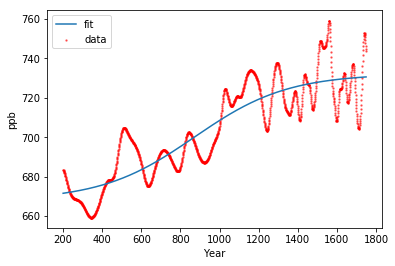

      Year                 CH4
0        1    690.147357180993
1        2   689.6209289909236
2        3   688.9892151628403
3        4   688.4627869727709
4        5   687.9363587827015
5        6   687.4099305926321
6        7   686.7782167645488
7        8   686.2517885744794
8        9   685.7253603844099
9       10   685.1989321943405
10      11   684.6725040042711
11      12   684.1460758142017
12      13   683.6196476241323
13      14   683.0932194340629
14      15   682.5667912439935
15      16   682.0403630539241
16      17   681.5139348638547
17      18   680.9875066737852
18      19   680.5663641217297
19      20   680.0399359316604
20      21   679.6187933796049
21      22   679.0923651895355
22      23   678.6712226374799
23      24   678.2500800854244
24      25    677.723651895355
25      26   677.3025093432994
26      27    676.881366791244
27      28   676.5655098772023
28      29   676.1443673251468
29      30   675.7232247730911
...    ...                 ...
1987  19

In [7]:
x = np.array(yrspre)
y = logistic(x, *popt)
plt.plot(x,y, label="fit")
plt.xlabel('Year')
plt.ylabel('ppb') 
plt.scatter(yrspre,ch4pre,s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
plt.legend(loc='best')
plt.savefig('ch42.eps',dpi=1000)
plt.show()

yrs = list(map(str, yrs))
yrs = pd.DataFrame({'Year':yrs})
ch4 = list(map(str, ch4))
ch4 = pd.DataFrame({'CH4':ch4})
df = pd.merge(yrs, ch4, left_index =True, right_index =True,how='outer')
print (df)
df.loc[-1]=['Julian','ppb']
df.index = df.index+1
df = df.sort_index()
df.loc[(len(df))] = ['2018/6/14','heat17ch4dec14.nb']
df.to_csv(filename + '.csv', index=False)